# Autoencoders for Image Reconstruction in Python and Keras
https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

# mount the colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For saving and retrieving the datasets
PATH_DATASETS = "/content/drive/MyDrive/Colab Notebooks/datasets/"

# Preprocessing Data

In [3]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = PATH_DATASETS + "lfw_attributes.txt"

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = PATH_DATASETS + "lfw-deepfunneled.tgz"

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = PATH_DATASETS + "lfw.tgz"

In [4]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [9]:
!pip install tqdm

In [14]:
import tarfile
import tqdm
import cv2
import os

def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

# Implementing the Autoencoder

In [15]:
import numpy as np
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

  0%|          | 0/18983 [00:00<?, ?it/s]

In [16]:
X = X.astype('float32') / 255.0 - 0.5

In [17]:
print(X.max(), X.min())

0.5 -0.5


In [18]:
import matplotlib.pyplot as plt
def show_image(x):
  plt.imshow(np.clip(x + 0.5, 0, 1))

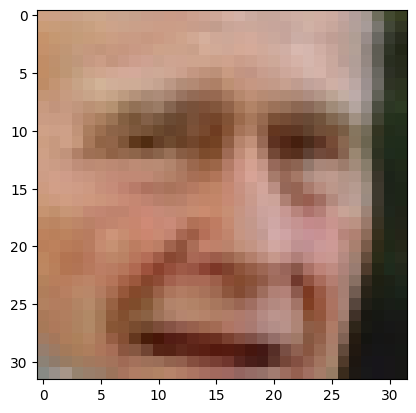

In [19]:
show_image(X[6])

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [22]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
  # The encoder
  encoder = Sequential()
  encoder.add(InputLayer(img_shape))
  encoder.add(Flatten())
  encoder.add(Dense(code_size))

  # The decoder
  decoder = Sequential()
  decoder.add(InputLayer((code_size, )))
  decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
  decoder.add(Reshape(img_shape))

  return encoder, decoder


In [23]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32)                98336     
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         101376    
                                                                 
Total params: 199712 (780.12 KB)
Trainable params: 199712 (780.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [24]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20, validation_data=[X_test, X_test])

Epoch 1/20
370/370 [==============================] - 7s 15ms/step - loss: 0.0148 - val_loss: 0.0104
Epoch 2/20
370/370 [==============================] - 5s 14ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 3/20
370/370 [==============================] - 4s 10ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 4/20
370/370 [==============================] - 4s 11ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 5/20
370/370 [==============================] - 4s 10ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 6/20
370/370 [==============================] - 3s 7ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/20
370/370 [==============================] - 3s 7ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/20
370/370 [==============================] - 3s 7ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/20
370/370 [==============================] - 3s 9ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
370/370 [==============================] - 4s 11ms/step - loss: 0.0066 - val_loss: 

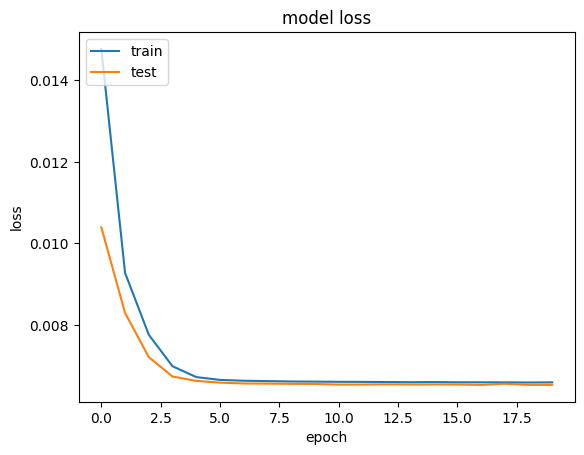

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 189ms/step


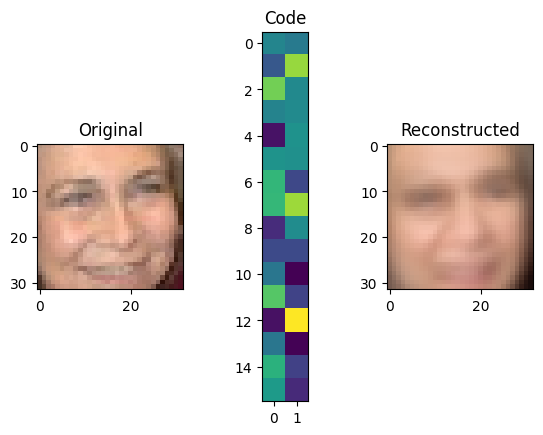

1/1 [==============================] - 0s 81ms/step


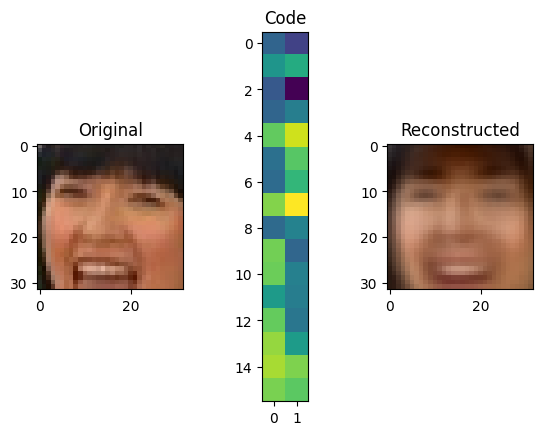

1/1 [==============================] - 0s 39ms/step


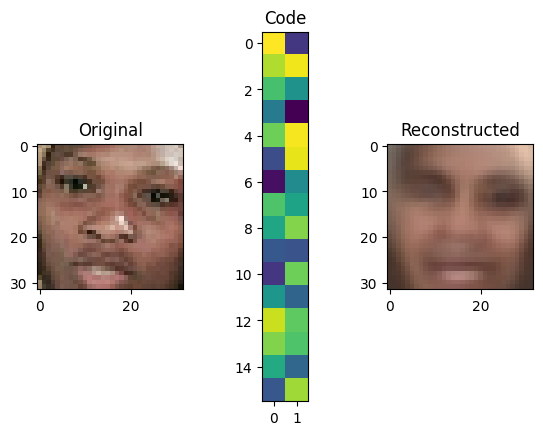

1/1 [==============================] - 0s 21ms/step


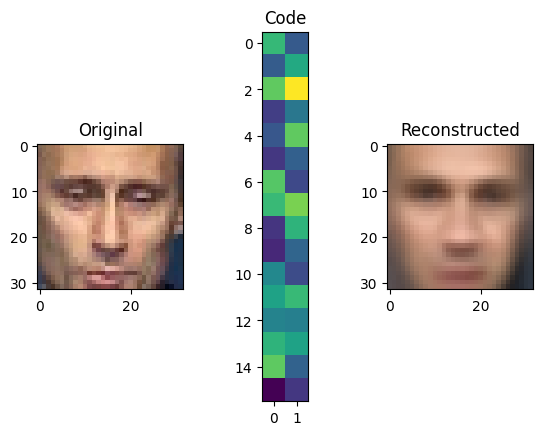

1/1 [==============================] - 0s 22ms/step


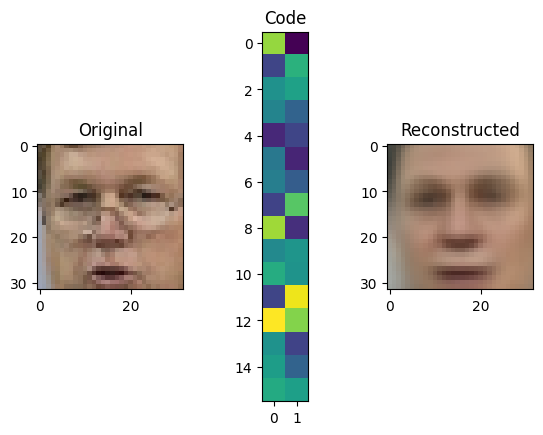

In [27]:
def visualize(img, encoder, decoder):
  """Draws original, encoded and decoded images"""

  code = encoder.predict(img[None])[0]
  reco = decoder.predict(code[None])[0]

  plt.subplot(1,3,1)
  plt.title("Original")
  show_image(img)

  plt.subplot(1,3,2)
  plt.title("Code")
  plt.imshow(code.reshape([code.shape[-1]//2,-1]))

  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  show_image(reco)
  plt.show()

for i in range(5):
  img = X_test[i]
  visualize(img, encoder, decoder)



# Image De-noising
Another popular usage of autoencoders is de-noising. Let's add some random noise to our pictures

In [28]:
# here we add some random noise from standard normal distrubution with a scale of sigma, which defaults to 0.1
def apply_gaussian_noise(X, sigma=0.1):
  noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
  return X + noise

In [29]:
# The model we'll be generating for this is the same as the one from before, though we'll train it differently.
# This time around, we'll train it with the original and corresponding noisy images:

code_size = 100

# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
  print("Epoch %i/25, Generating corrupted samples..."%(i+1))
  X_train_noise = apply_gaussian_noise(X_train)
  X_test_noise = apply_gaussian_noise(X_test)

  # We continue to train our model with new noise-augmented data
  autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                  validation_data=[X_test_noise, X_test])

Epoch 1/25, Generating corrupted samples...
370/370 [==============================] - 11s 26ms/step - loss: 0.0131 - val_loss: 0.0087
Epoch 2/25, Generating corrupted samples...
370/370 [==============================] - 8s 20ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 3/25, Generating corrupted samples...
370/370 [==============================] - 8s 21ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 4/25, Generating corrupted samples...
370/370 [==============================] - 6s 16ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 5/25, Generating corrupted samples...
370/370 [==============================] - 7s 19ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 6/25, Generating corrupted samples...
370/370 [==============================] - 5s 13ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/25, Generating corrupted samples...
370/370 [==============================] - 6s 17ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/25, Generating corrupted samples...
370/370 [========

1/1 [==============================] - 0s 66ms/step


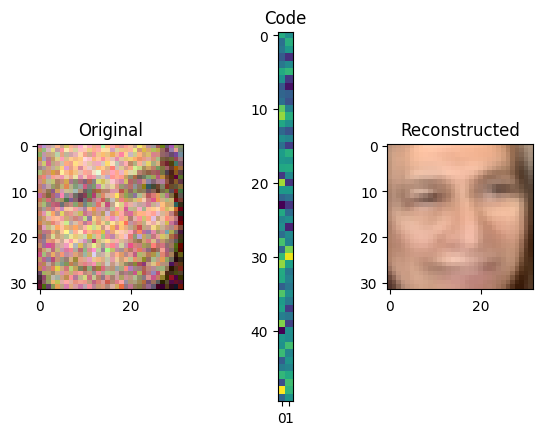

1/1 [==============================] - 0s 31ms/step


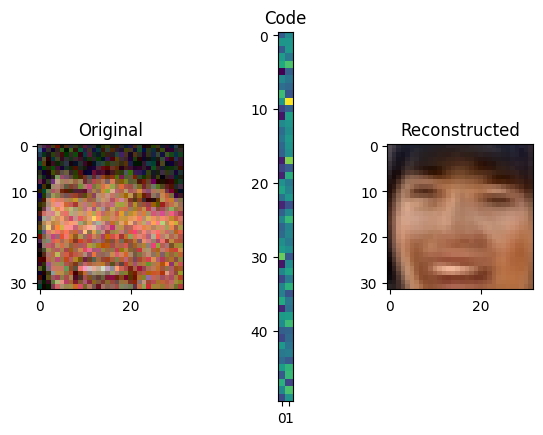

1/1 [==============================] - 0s 33ms/step


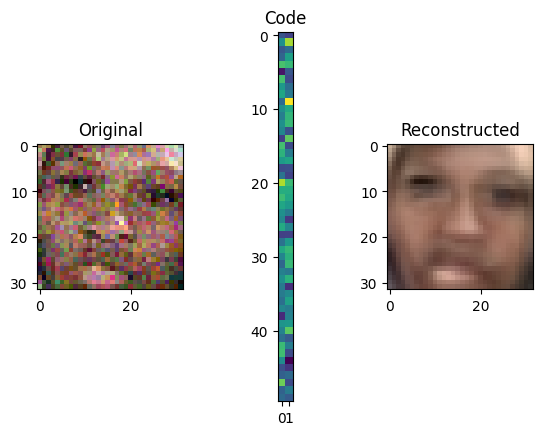

1/1 [==============================] - 0s 34ms/step


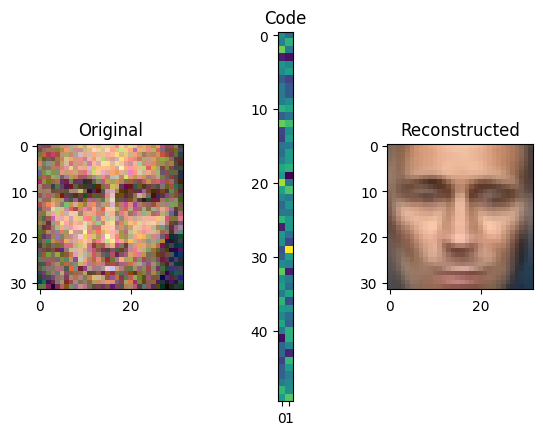

1/1 [==============================] - 0s 32ms/step


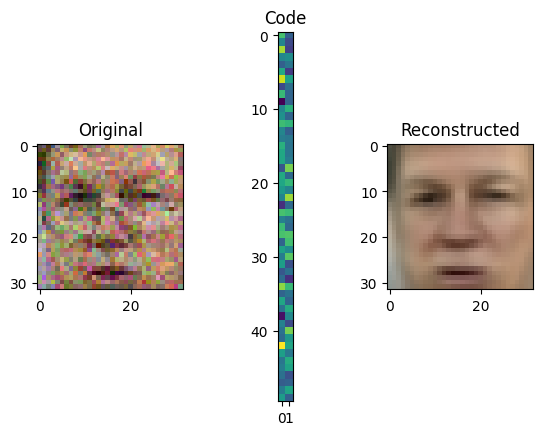

In [30]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
  img = X_test_noise[i]
  visualize(img, encoder, decoder)